# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

In [2]:
df = pd.read_csv('/datasets/taxi.csv',parse_dates=[0], index_col=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.sort_index(inplace=True)

In [6]:
#resampling by 1 hour
df = df.resample('1H').sum()

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

In [8]:
df.isna().sum()

num_orders    0
dtype: int64

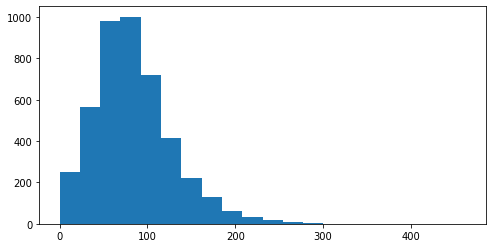

In [9]:
plt.figure(figsize=(8,4))
plt.hist(df, bins=20)
plt.show()

There is a skewed right distribution. 

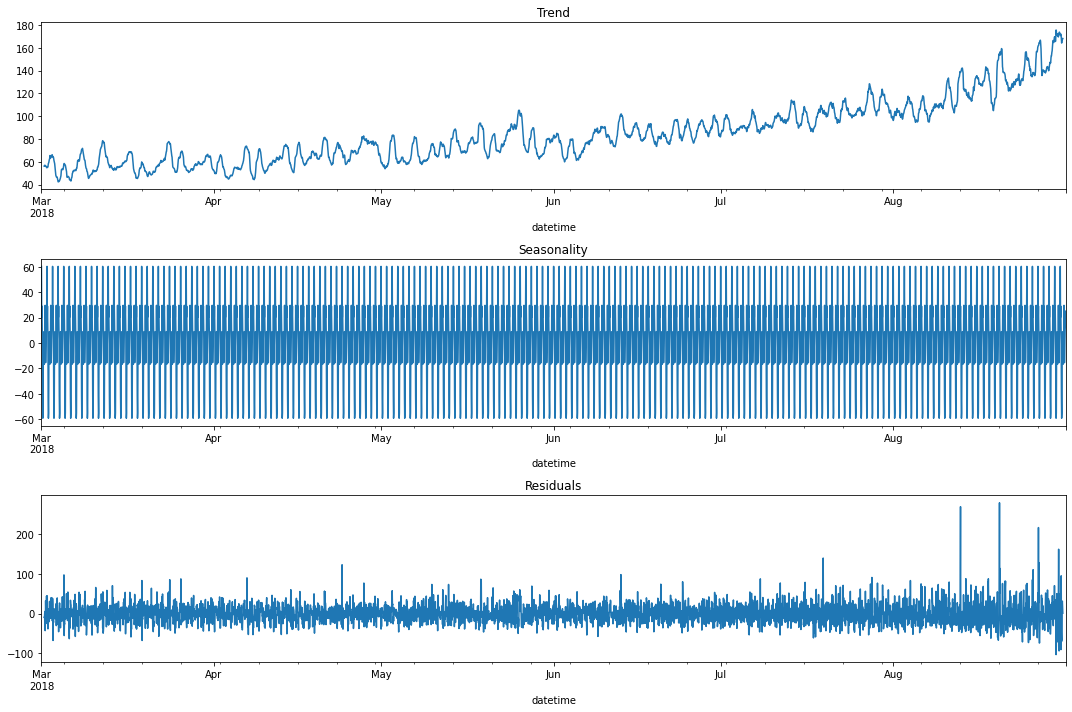

In [15]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

There's an increase in trend during summer months. 

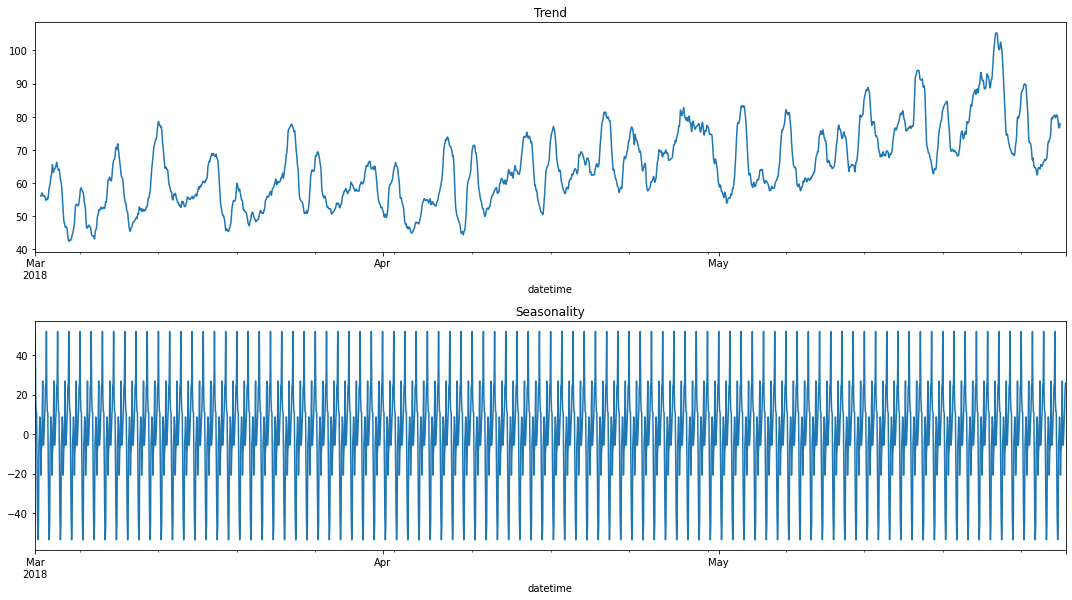

In [188]:
spring = df['2018-03':'2018-05']

decomposed = seasonal_decompose(spring)

plt.figure(figsize=(15, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

End of April-May is busiest spring times.

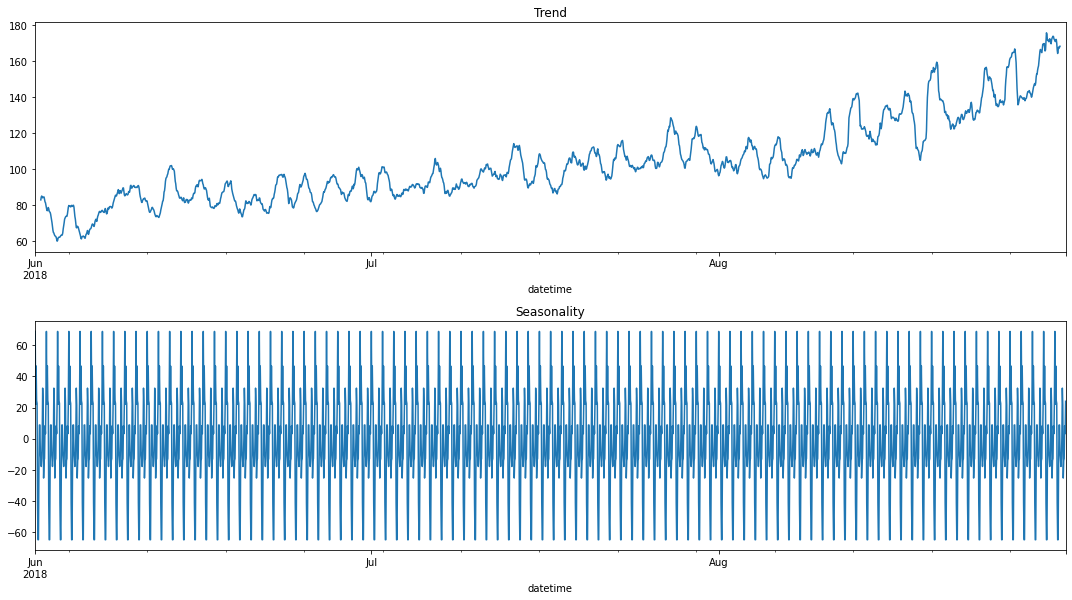

In [189]:
summer = df['2018-06':'2018-08']

decomposed = seasonal_decompose(summer)

plt.figure(figsize=(15, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

There's an upward trend during August.

Text(0.5, 1.0, 'Seasonality')

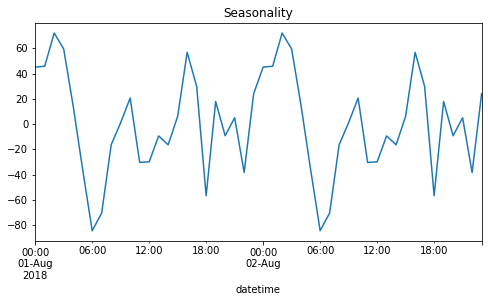

In [23]:
august = df['2018-08-01' : '2018-08-02']

decomposed = seasonal_decompose(august)

plt.figure(figsize=(8, 4))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

Orders are at its lowest at 6 in the morning and at its highest after midnight. Demand is highly variable. 

In [25]:
rolling_mean = df.rolling(10).mean()

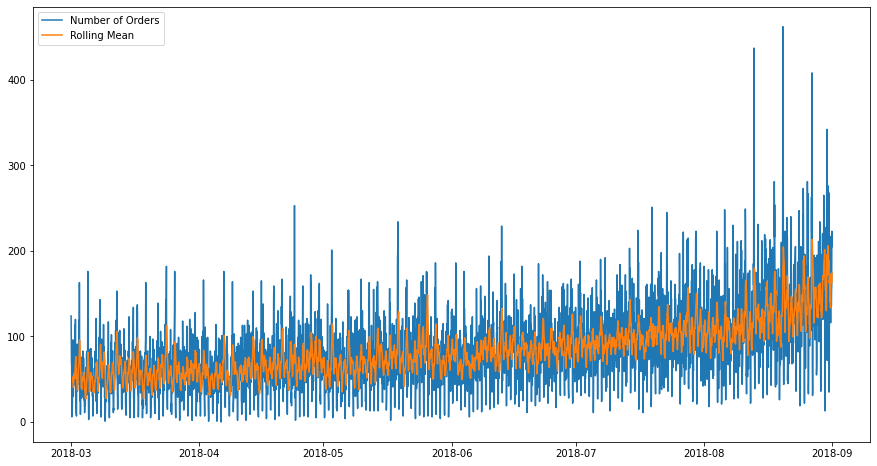

In [31]:
plt.figure(figsize=(15, 8))
plt.plot(df)
plt.plot(rolling_mean)
plt.legend(['Number of Orders', 'Rolling Mean'])
plt.show()

## Training

In [192]:
#Creating features
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag, fill_value=0)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean().fillna(0)

make_features(df, 12, 10)
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2018-03-01 01:00:00,85,3,1,3,1,124,0,0,0,0,0,0,0,0,0,0,0,0.0
2018-03-01 02:00:00,71,3,1,3,2,85,124,0,0,0,0,0,0,0,0,0,0,0.0
2018-03-01 03:00:00,66,3,1,3,3,71,85,124,0,0,0,0,0,0,0,0,0,0.0
2018-03-01 04:00:00,43,3,1,3,4,66,71,85,124,0,0,0,0,0,0,0,0,0.0


In [193]:
#Weekday or weekend
def typeofday(dayofweek):
    if dayofweek == 5:
        return 1
    if dayofweek == 6:
        return 1
    else:
        return 0

In [194]:
df['typeofday'] = df['dayofweek'].apply(typeofday)

In [196]:
#Time of the day(morning, afternoon, evening)
def timeofday(hour):
    if  0 <= hour <= 12:
        return 1
    if 12 < hour <= 18:
        return 2
    else:
        return 3
    

In [197]:
df['timeofday'] = df['hour'].apply(timeofday)

In [198]:
#Features and target
x = df.drop('num_orders', axis=1)
y = df['num_orders']

In [199]:
#Splitting data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, shuffle = False, random_state=42)

### Decision Tree Model

In [200]:
param_desc = {'max_depth' : [1,2,3,4,5,6,7,8,9,10]}

In [201]:
model_desc = DecisionTreeRegressor(random_state = 42)

In [202]:
grid_desc = GridSearchCV(model_desc, param_desc, cv=5, n_jobs=5, scoring='neg_root_mean_squared_error')

In [203]:
grid_desc.fit(x_train, y_train)
print('Best Parameters:',grid_desc.best_params_)
print('Best Score:',grid_desc.best_score_)

Best Parameters: {'max_depth': 7}
Best Score: -29.21884373909925


### Random Forest Model

In [204]:
param_rand = {'max_depth': [1,2,3,4,5,6,7,8,9,10],
              'n_estimators': [5,6,7,8,9,10,11,12,13,14,15]}

In [205]:
model_rand = RandomForestRegressor(random_state=42)

In [206]:
grid_rand = GridSearchCV(model_rand, param_rand, cv=5, n_jobs=5, scoring='neg_root_mean_squared_error')

In [207]:
grid_rand.fit(x_train, y_train)
print('Best Parameters:',grid_rand.best_params_)
print('Best Score:',grid_rand.best_score_)

Best Parameters: {'max_depth': 10, 'n_estimators': 15}
Best Score: -24.980072952781928


### Linear Regression Model

In [208]:
model_lin = LinearRegression()
score = cross_val_score(model_lin, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
final_score = score.sum() / len(score)
print('RMSE =',np.sqrt(-final_score))

RMSE = 16838623998039.65


### LightGBM

In [209]:
param_gbm = {'learning_rate': [1, 0.1,0.5],
         'max_depth': [6,7,8,9,10],
         'num_leaves': [5,6,7,8,9,10]
          }

In [210]:
model_gbm = LGBMRegressor(random_state=42)

In [211]:
grid_gbm = GridSearchCV(model_gbm, param_gbm, cv=5, n_jobs=5, scoring='neg_root_mean_squared_error',verbose=-1)

In [212]:
grid_gbm.fit(x_train, y_train)
print('Best Parameters:',grid_gbm.best_params_)
print('Best Score:',grid_gbm.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 10}
Best Score: -23.53351593880124


## Testing

In [213]:
model = LGBMRegressor(**grid_gbm.best_params_,random_state=42)

In [214]:
model.fit(x_train,y_train)

LGBMRegressor(max_depth=6, num_leaves=10, random_state=42)

In [215]:
y_pred = model.predict(x_test)

In [216]:
print('RMSE = ', np.sqrt(mean_squared_error(y_pred, y_test)))

RMSE =  42.699909073222045


# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48

## Conclusion

The data was prepared and analyzed. The demand for taxis is variable thoroughout the day. The highest demand is after mignight while the lowest demand is at 6am. The trend increases during summer months, highest in August. 4 models were trained and Lightgbm was found to be the best choice based on RMSE. The final RMSE score on the test set was found to be 42.7.